# Steps to EQ Rotta

*Authors: Antony Sikorski, Sara Shamekh*

My modifications to the original EQ-Rotta notebook. Significant changes: 

- slightly different file finding function
- time average function now works for 1d and 2d data. 
- Using multiple files at once (this means quite a bit more work for variables, constants, etc) 

In [1]:
# from pdfs import *
import os

import xarray as xr
import netCDF4 as nc
import h5netcdf

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

Should return all files and folders that start with 'Ug', although in our case right now it should just be files: 

In [2]:
def list_directories_files(path):
    # all items in the given path
    items = os.listdir(path)
    
    # find the directories starting with 'Ug'
    directories = [item for item in items if os.path.isdir(os.path.join(path, item)) and item.startswith('Ug')]
    # find the files starting with 'Ug'
    files = [item for item in items if os.path.isfile(os.path.join(path, item)) and item.startswith('Ug')]
    
    return directories, files


This lists all of our files. **All that needs to be changed is the path.** 

In [3]:
path = 'C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim_2/'


directories, files = list_directories_files(path)
print("Directories starting with 'Ug':", directories)
print("Files starting with 'Ug':", files)

Directories starting with 'Ug': []
Files starting with 'Ug': ['Ug16Q000_IV.nc', 'Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_I.nc', 'Ug16Q006_IV.nc', 'Ug16Q010_IV.nc', 'Ug1Q01_II.nc', 'Ug2Q010_I.nc', 'Ug2Q010_IV.nc', 'Ug2Q01_III.nc', 'Ug2Q024_I.nc', 'Ug8Q003_II.nc', 'Ug8Q003_III.nc', 'Ug8Q003_IV.nc', 'Ug8Q006_IV.nc']


In [4]:
# nc_test1 = nc.Dataset(os.path.join('C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim_2/', 'Ug2Q010_I.nc'), mode='r')

# z_256 = nc_test1.variables['z'][:]
# zh_257 = nc_test1.variables['zh'][:]
# t_120 = nc_test1.variables['time'][:]

# #rewrite this code but using 'Ug2Q010_IV.nc' instead
# nc_test2 = nc.Dataset(os.path.join('C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim_2/', 'Ug2Q010_IV.nc'), mode='r')

# z_384 = nc_test2.variables['z'][:]
# zh_385 = nc_test2.variables['zh'][:]
# t_90 = nc_test2.variables['time'][:]

# # print(len(z_256), len(zh_257), len(t_120), len(z_384), len(zh_385), len(t_90))

In [5]:
def time_average(data, timeavg):
    """
    Averages an array over specified number of time steps. Works for both 1D and higher-dimensional arrays.

    Parameters:
    - data (numpy.ndarray): The input data array. Expected shapes are either (ntime,) or (ntime, nz).
    - timeavg (int): The number of time steps over which to average.

    Returns:
    - numpy.ndarray: The averaged data array.
    """
    ntime = data.shape[0]
    nchunks = ntime // timeavg
    truncated_data = data[:nchunks * timeavg]

    if data.ndim == 1:
        # for 1D arrays, reshape to (nchunks, timeavg)
        reshaped_data = truncated_data.reshape(nchunks, timeavg)
    else:
        # for 2D arrays, old method with reshaping
        nz = data.shape[1]
        reshaped_data = truncated_data.reshape(nchunks, timeavg, nz)

    # compute the mean along the new time axis 
    averaged_data = reshaped_data.mean(axis=1)

    return averaged_data


In [6]:
items = files

time_avg = 15

for item in items:
    ds_stat = nc.Dataset( os.path.join(path, item), mode='r')
    if 'budget' in ds_stat.groups:
        print ("budget is in", item)
    else:
        print ("budget is not in", item)
    

budget is not in Ug16Q000_IV.nc
budget is in Ug16Q001_IV.nc
budget is in Ug16Q003_IV.nc
budget is in Ug16Q006_I.nc
budget is in Ug16Q006_IV.nc
budget is in Ug16Q010_IV.nc
budget is in Ug1Q01_II.nc
budget is in Ug2Q010_I.nc
budget is in Ug2Q010_IV.nc
budget is in Ug2Q01_III.nc
budget is in Ug2Q024_I.nc
budget is in Ug8Q003_II.nc
budget is in Ug8Q003_III.nc
budget is in Ug8Q003_IV.nc
budget is in Ug8Q006_IV.nc


It appears that we can use all files except the very first (000) file. Going to print out all of the viable files so we can see dimension sizes and groups: 

In [7]:
for item in items[1:]:
    print(item)
    df = nc.Dataset(path + '/' + item, mode='r')
    print(df)

Ug16Q001_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q003_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q006_I.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q006_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(90)
    variables(dimensions): float64 time(time), float64 z(z), f

This function should create variables for a given list of `items`. In my case, my `selected_files` constitutes a group of similar (I think) simulations that I can append together for the sake of having more data.  

In [8]:
selected_files = [items[1], items[2], items[4], items[5]]
# selected_files = [items[1]]

In [9]:
def make_variables(path, items, time_avg):
    # Initialize empty lists to accumulate results
    sigma_th = []
    sigma_2 = []
    Theta = []
    wtheta = []
    wwtheta = []
    rdstr = []
    transport = []

    for item in items:
        ds_stat = nc.Dataset(os.path.join(path, item), mode='r')
        
        sigma_th_temp = time_average(ds_stat.groups['thermo']['th_2'][:], time_avg)  # covariance of theta
        sigma_2_temp = time_average(ds_stat.groups['default']['w_2'][:], time_avg)   # covariance of w
        Theta_temp = time_average(ds_stat.groups['thermo']['th'][:], time_avg)       # domain mean theta
        wtheta_temp = time_average(ds_stat.groups['thermo']['th_flux'][:], time_avg) # heat flux
        wwtheta_temp = time_average(ds_stat.groups['budget']['wwtheta'][:], time_avg) # third moment, covariance between wtheta and w
        rdstr_temp = time_average(ds_stat.groups['budget']['bw_rdstr'][:], time_avg)
        transport_temp = time_average(ds_stat.groups['budget']['bw_pres'][:], time_avg)

        # Append the results to the respective lists
        sigma_th.append(sigma_th_temp)
        sigma_2.append(sigma_2_temp)
        Theta.append(Theta_temp)
        wtheta.append(wtheta_temp)
        wwtheta.append(wwtheta_temp)
        rdstr.append(rdstr_temp)
        transport.append(transport_temp)

    # Concatenate the results along the time axis
    sigma_th = np.concatenate(sigma_th, axis=0)
    sigma_2 = np.concatenate(sigma_2, axis=0)
    Theta = np.concatenate(Theta, axis=0)
    wtheta = np.concatenate(wtheta, axis=0)
    wwtheta = np.concatenate(wwtheta, axis=0)
    rdstr = np.concatenate(rdstr, axis=0)
    transport = np.concatenate(transport, axis=0)

    return sigma_th, sigma_2, Theta, wtheta, wwtheta, rdstr, transport

In [10]:
sigma_th, sigma_2, Theta, wtheta, wwtheta, rdstr, transport = make_variables(path, selected_files, time_avg)

# z = np.arange(0, 384)
# zh = np.arange(0, 385)
# t = np.arange(0, 120)

z = ds_stat.variables['z'][:]
zh = ds_stat.variables['zh'][:]
t = ds_stat.variables['time'][:]


dTheta_dz = np.gradient(Theta, z, axis = 1)
dwwtheta_dz = np.gradient(wwtheta, zh, axis = 1)

print(zh.shape, z.shape, t.shape)

(385,) (384,) (120,)


Let's take a look at all of the variables (including gradients) that we create> We print their:

Name, shape, mean, and standard deviation

In [11]:
print("dTheta_dz", dTheta_dz.shape, np.mean(dTheta_dz), np.std(dTheta_dz))
print("sigma_th", sigma_th.shape, np.mean(sigma_th), np.std(sigma_th))
print("sigma_2", sigma_2.shape, np.mean(sigma_2), np.std(sigma_2))
print("Theta", Theta.shape, np.mean(Theta), np.std(Theta))
print("wtheta", wtheta.shape, np.mean(wtheta), np.std(wtheta))
print("wwtheta", wwtheta.shape, np.mean(wwtheta), np.std(wwtheta))
print("dwwtheta_dz", dwwtheta_dz.shape, np.mean(dwwtheta_dz), np.std(dwwtheta_dz))
print("rdtsr", rdstr.shape, np.mean(rdstr), np.std(rdstr))
print("transport", transport.shape, np.mean(transport), np.std(transport))

dTheta_dz (28, 384) 0.0030314636318719093 0.0030829971488603295
sigma_th (28, 384) 0.012444759205988804 0.019345171885376777
sigma_2 (28, 385) 0.2186071548482508 0.2719143169874343
Theta (28, 384) 302.9677230539196 2.4932242069071053
wtheta (28, 385) 0.005174151995554143 0.018592449543324292
wwtheta (28, 385) 0.0068160878 0.018759899
dwwtheta_dz (28, 385) 1.1788919595707768e-08 0.00012012300681359305
rdtsr (28, 385) -5.9081866084689566e-06 1.9059345351241784e-05
transport (28, 385) -8.502757699630559e-07 1.799674840107782e-05


In [12]:
print(wwtheta[1,0:3])
print((wwtheta[1,0]+wwtheta[1,1])/2, (wwtheta[1,1]+wwtheta[1,2])/2)

[ 0.0000000e+00 -3.1880256e-05 -1.0963364e-04]
-1.594012792338617e-05 -7.075694884406403e-05


Variables that have a second dimension of 385 are calculated at zh values of 0, 6, 12, and so on. Variables with 384 are staggered and calculated in between there, at values of 3, 9, 15, and so on. We reshape the 385's to be 384's by taking the average of each consecutive pair. 

We test if this works above and below with old and new values of `wwtheta` (just a sanity check)

In [13]:
def reshape_variables(variable):
    reshaped = (variable[:, :-1] + variable[:, 1:]) / 2.0
    return reshaped

In [14]:
sigma_2 = reshape_variables(sigma_2)
wtheta = reshape_variables(wtheta)
wwtheta = reshape_variables(wwtheta)
dwwtheta_dz = reshape_variables(dwwtheta_dz)
rdstr = reshape_variables(rdstr)
transport = reshape_variables(transport)

In [15]:
print("dTheta_dz", dTheta_dz.shape, np.mean(dTheta_dz), np.std(dTheta_dz))
print("sigma_th", sigma_th.shape, np.mean(sigma_th), np.std(sigma_th))
print("sigma_2", sigma_2.shape, np.mean(sigma_2), np.std(sigma_2))
print("Theta", Theta.shape, np.mean(Theta), np.std(Theta))
print("wtheta", wtheta.shape, np.mean(wtheta), np.std(wtheta))
print("wwtheta", wwtheta.shape, np.mean(wwtheta), np.std(wwtheta))
print("dwwtheta_dz", dwwtheta_dz.shape, np.mean(dwwtheta_dz), np.std(dwwtheta_dz))

dTheta_dz (28, 384) 0.0030314636318719093 0.0030829971488603295
sigma_th (28, 384) 0.012444759205988804 0.019345171885376777
sigma_2 (28, 384) 0.21917644431400146 0.27201662125737475
Theta (28, 384) 302.9677230539196 2.4932242069071053
wtheta (28, 384) 0.005128102540185422 0.018518388108091755
wwtheta (28, 384) 0.006833837855429877 0.01877758606482776
dwwtheta_dz (28, 384) -2.5444197013885493e-13 0.00011980481075705457


In [16]:
print(wwtheta[1,0:2])

[-1.594012792338617e-05 -7.075694884406403e-05]


Plotting all variables at a given timestep just for a sanity check: 

Text(0.5, 1.0, '(dwwtheta_dz)')

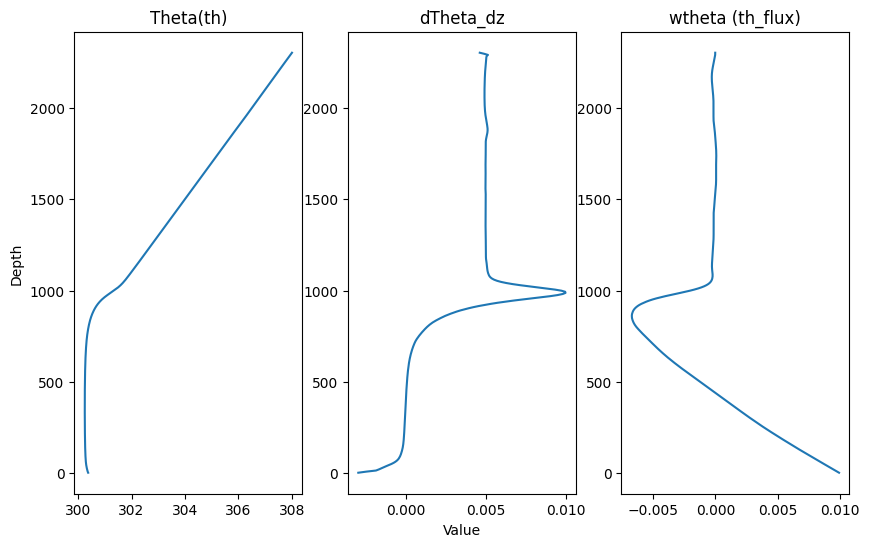

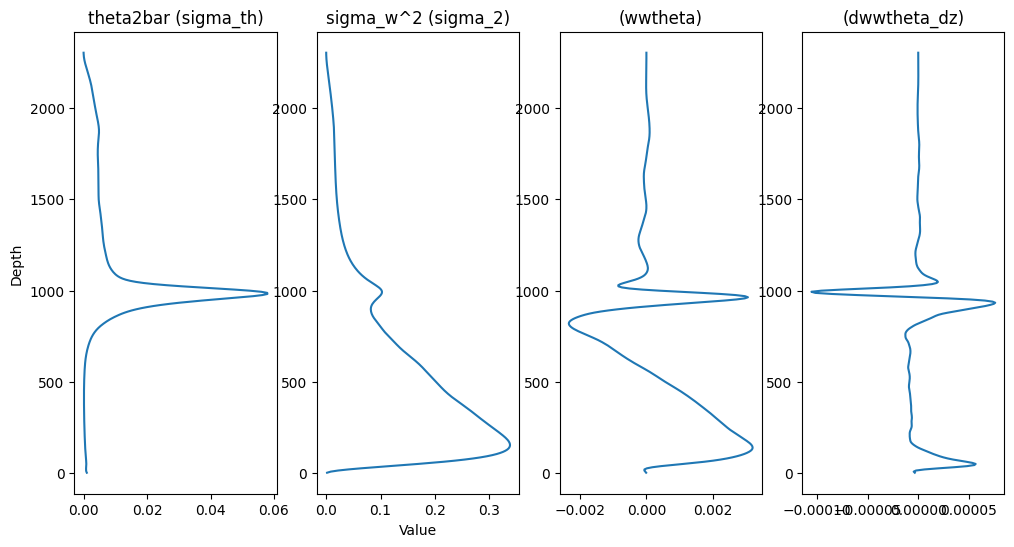

In [17]:
timeStep = 6

plt.figure(figsize = (10, 6))

# Plot potentialTemp
plt.subplot(1, 3, 1)
#plt.plot(Theta[timeStep], np.arange(0, len(Theta[timeStep,:])))
plt.plot(Theta[timeStep], z)
plt.title('Theta(th)')
# plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 3, 2)
# plt.plot(dTheta_dz[timeStep], np.arange(0, len(dTheta_dz[timeStep,:])))
plt.plot(dTheta_dz[timeStep], z)
plt.title('dTheta_dz')
plt.xlabel('Value')
# plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 3, 3)
# plt.plot(wtheta[timeStep], np.arange(0, len(wtheta[timeStep,:])))
plt.plot(wtheta[timeStep], z)
plt.title('wtheta (th_flux)')
# plt.xlabel('Value')
# plt.ylabel('Depth')


plt.figure(figsize = (12, 6))

# Plot potentialTemp
plt.subplot(1, 4, 1)
# plt.plot(sigma_th[timeStep], np.arange(0, len(sigma_th[timeStep,:])))
plt.plot(sigma_th[timeStep], z)
plt.title('theta2bar (sigma_th)')
# plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 4, 2)
# plt.plot(sigma_2[timeStep], np.arange(0, len(sigma_2[timeStep,:])))
plt.plot(sigma_2[timeStep], z)
plt.title('sigma_w^2 (sigma_2)')
plt.xlabel('Value')
# plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 4, 3)
# plt.plot(wwtheta[timeStep], np.arange(0, len(wwtheta[timeStep,:])))
plt.plot(wwtheta[timeStep], z)
plt.title('(wwtheta)')
# plt.xlabel('Value')
# plt.ylabel('Depth')

plt.subplot(1, 4, 4)
# plt.plot(dwwtheta_dz[timeStep], np.arange(0, len(dwwtheta_dz[timeStep,:])))
plt.plot(dwwtheta_dz[timeStep], z)
plt.title('(dwwtheta_dz)')
# plt.xlabel('Value')
# plt.ylabel('Depth')

## Diagnosing constants: 
Often we use conventional constant to normalize profiles. Here are some of the typical ones used in the PBL. 

AS added note: This modified function calculates the constants once again for a list of different simulations. 

In [18]:
grr = 9.8
T_0 = 300
beta = grr/T_0

def make_constants(path, items, time_avg):
    wtheta_surface = []
    pbl_height = []
    wstar = []
    theta_star = []
    scaling = []
    ustar = []

    for item in items:
        ds_stat = nc.Dataset(os.path.join(path, item), mode='r')

        wtheta_surface_raw = ds_stat.groups['thermo']['th_flux'][:,0] 
        wtheta_surface_temp = time_average(wtheta_surface_raw, time_avg)

        pbl_height_raw = ds_stat.groups['thermo'].variables['zi'][:] 
        pbl_height_temp = time_average(pbl_height_raw, time_avg)

        wstar_raw = np.power( beta * (wtheta_surface_raw) * pbl_height_raw , 1/3) 
        wstar_temp = time_average(wstar_raw, time_avg)

        theta_star_raw = wtheta_surface_raw / wstar_raw
        theta_star_temp = time_average(theta_star_raw, time_avg)

        scaling_raw = wstar_raw**2 * theta_star_raw / pbl_height_raw
        scaling_temp = time_average(scaling_raw, time_avg)

        ustar_temp = time_average(ds_stat.groups['default'].variables['ustar'][:], time_avg)

        wtheta_surface.append(wtheta_surface_temp)
        pbl_height.append(pbl_height_temp)
        wstar.append(wstar_temp)
        theta_star.append(theta_star_temp)
        scaling.append(scaling_temp)
        ustar.append(ustar_temp)

    wtheta_surface = np.concatenate(wtheta_surface, axis=0)
    pbl_height = np.concatenate(pbl_height, axis=0)
    wstar = np.concatenate(wstar, axis=0)
    theta_star = np.concatenate(theta_star, axis=0)
    scaling = np.concatenate(scaling, axis=0)
    ustar = np.concatenate(ustar, axis=0)

    wtheta_surface = wtheta_surface[:,np.newaxis]
    pbl_height = pbl_height[:,np.newaxis]
    wstar = wstar[:,np.newaxis]
    theta_star = theta_star[:,np.newaxis]
    scaling = scaling[:,np.newaxis]
    ustar = ustar[:,np.newaxis]

    return wtheta_surface, pbl_height, wstar, theta_star, scaling, ustar

In [19]:
wtheta_surface, pbl_height, wstar, theta_star, scaling, ustar = make_constants(path, selected_files, time_avg)

Once again printing 

Name, shape, mean, and standard deviation

of the constants (if they are time dependent). 

In [20]:
print("wtheta_surface", wtheta_surface.shape, np.mean(wtheta_surface), np.std(wtheta_surface))
print("pbl_height", pbl_height.shape, np.mean(pbl_height), np.std(pbl_height))
print("wstar", wstar.shape, np.mean(wstar), np.std(wstar))
print("theta_star", theta_star.shape, np.mean(theta_star), np.std(theta_star))
print("scaling", scaling.shape, np.mean(scaling), np.std(scaling))
print("ustar", ustar.shape, np.mean(ustar), np.std(ustar))
print("grr", grr)
print("T_0", T_0)
print("beta", beta)

wtheta_surface (28, 1) 0.04571428571428573 0.03331972511340172
pbl_height (28, 1) 1062.7857142857142 95.67429761691379
wstar (28, 1) 1.0951109534773777 0.3285708633112884
theta_star (28, 1) 0.036334221047992846 0.018176987805097276
scaling (28, 1) 5.391947016099851e-05 4.70345197903405e-05
ustar (28, 1) 0.6342496824822691 0.04272436845471656
grr 9.8
T_0 300
beta 0.03266666666666667


## Compute the P term as residual
Equation 11 in the paper suggest that, assuming that the left hand side is smaller compared to terms on the right hnd side. 

AS added note: I compute the equation up to 384 as not all variables go up to 385. 



**Long description:** 

The equation in question is the heat flux budget in the convective boundary layer, which is written as: 

$$
\frac{\partial \overline{w \theta}}{\partial t}=0=\underbrace{-\sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}}_M \underbrace{-\frac{\mathrm{d} \overline{w w \theta}}{\mathrm{d} z}}_T \underbrace{-\frac{1}{\rho_0} \theta \frac{\mathrm{d} p}{\mathrm{~d} z}}_P \underbrace{+\beta \overline{\theta^2}}_B
$$

Production terms: Mean gradient production ($M$), and bouyancy production ($B$). Destruction terms: turbulent flux transport ($T$) and the the pressure gradient–potential temperature covariance ($P$). 

$P$ acts as a destruction/sink term for the heat flux $\overline{w \theta}$. The general form for the parametrization of $P$ is

$$
P=-\frac{1}{\rho_0} \overline{\theta \frac{\mathrm{d} p}{\mathrm{~d} z}}=-C_1 \frac{\overline{w \theta}}{\tau_1} - C_2 \beta \overline{\theta^2} + C_3 \sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}
$$

The first term $-C_1 \frac{\overline{w \theta}}{\tau_1}$ is the "slow" term. It is Rotta's return to isotropy part. Is inversely proportional to time scale $\tau_1$. I think it may also be called the "turbulence-turbulence" interaction. The last two terms are the "rapid" part, with $C_2 \beta \overline{\theta^2}$ being the bouyancy term, and $C_3 \sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}$ being the shear-turbulence term. 

In [21]:
M = (sigma_2 * dTheta_dz)
T = dwwtheta_dz
B = (beta * sigma_th)

P = M + T - B
P.shape

(28, 384)

In [22]:
print(f"{np.mean(B):.7f}, {np.std(B):.7f}")
print(f"{np.mean(M):.7f}, {np.std(M):.7f}")
print(f"{np.mean(T):.7f}, {np.std(T):.7f}")
print(f"{np.mean(P):.7f}, {np.std(P):.7f}")

0.0004065, 0.0006319
0.0001853, 0.0004001
-0.0000000, 0.0001198
-0.0002212, 0.0003477


In [23]:
max(P[6])
min(P[6])

min(P[6])/max(P[6])

-74.19401168248785

## Comparing P term and original rotta model plot
Lets reproduce plot 6 of the turbulece asymmetry paper to make sure we have all terms looking "somewhat" similar. "somewhat" because the rotta model may not be very accurate. 

Text(0, 0.5, 'Depth')

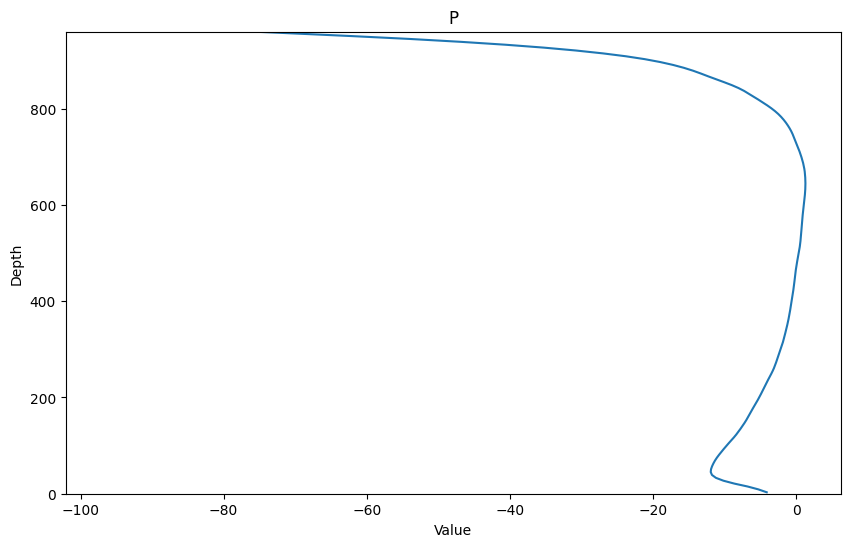

In [24]:
plt.figure(figsize = (10, 6))
plt.plot(P[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z)
plt.ylim(0,960)
plt.title('P')
plt.xlabel('Value')
plt.ylabel('Depth')

# Cutting out near surface part
Some of the assumptions we make when computing P as a residual may not hold near the surface. Therefore, before preparing data for EQ, we remove the near-surface part of the profile, typically the top 7-10 layers

Text(0, 0.5, 'Depth')

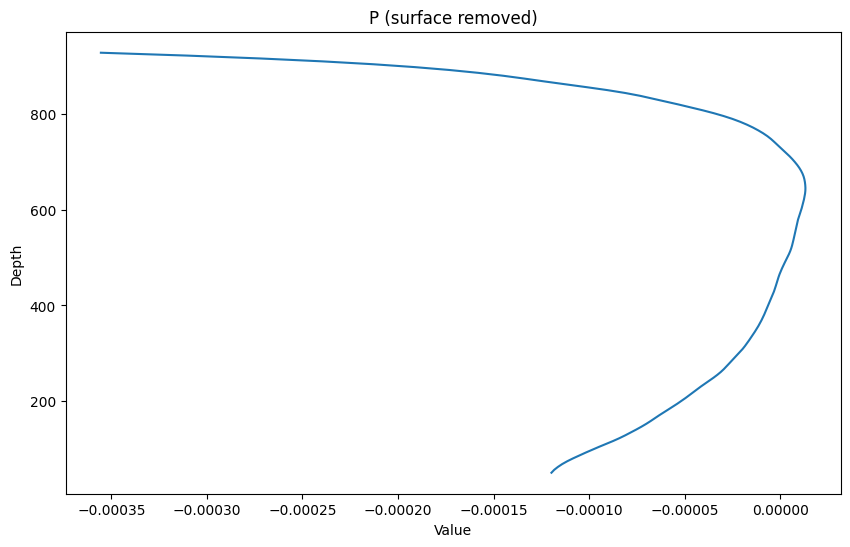

In [25]:
P_trim = P[:, 8:155]
P_trim.shape

plt.figure(figsize = (10, 6))
plt.plot(P_trim[timeStep], z[8:155])
plt.title('P (surface removed)')
plt.xlabel('Value')
plt.ylabel('Depth')

## Comparing P to alternative method for calculating it

Here we calculate P directly rather than as a residual, and compare the plots. 

Text(0, 0.5, 'Depth')

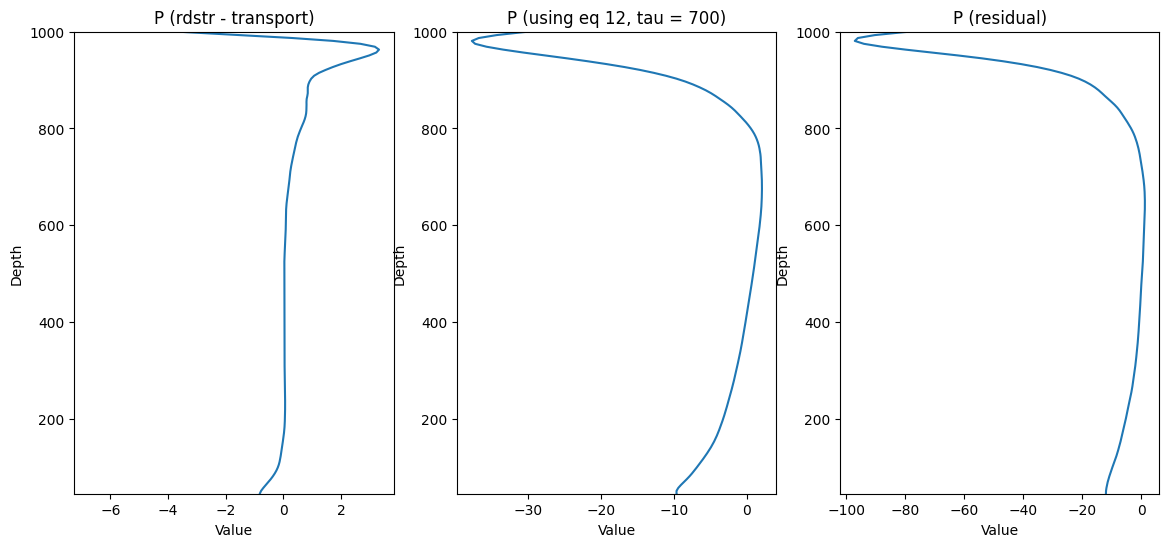

In [26]:
P_subtract = rdstr - transport

tau1 = 1000 #unsure about this one at the moment, huge number makes it look correct though

P_direct = - (3 * wtheta/tau1) - (5/12 * beta * sigma_th) + (2/5 * sigma_2 * dTheta_dz)

plt.figure(figsize = (14, 6))

plt.subplot(1,3,1)
plt.plot(P_subtract[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z)
plt.ylim(45,1000)
plt.title('P (rdstr - transport)')
plt.xlabel('Value')
plt.ylabel('Depth')

plt.subplot(1,3,2)
plt.plot(P_direct[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z)
plt.title('P (using eq 12, tau = 700)')
plt.ylim(45,1000)
plt.xlabel('Value')
plt.ylabel('Depth')

plt.subplot(1,3,3)
plt.plot(P[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z)
plt.title('P (residual)')
plt.ylim(45,1000)
plt.xlabel('Value')
plt.ylabel('Depth')

Looking at `rdtsr` and `transport` alone is a good sanity check before we abandon their use entirely

Text(0, 0.5, 'Depth')

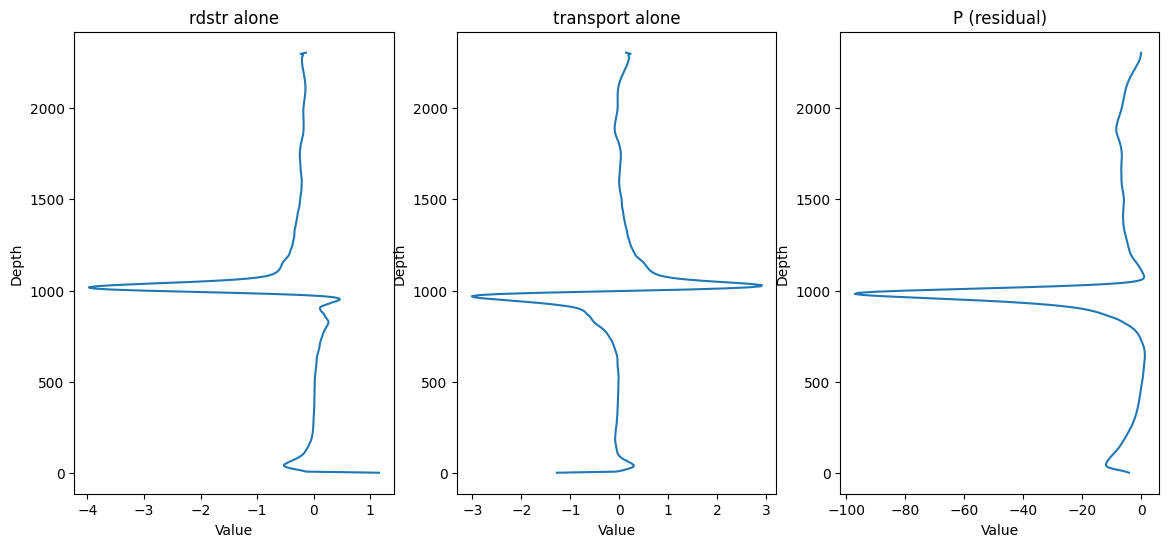

In [27]:
plt.figure(figsize = (14, 6))

plt.subplot(1,3,1)
plt.plot(rdstr[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z)
# plt.ylim(45,1000)
plt.title('rdstr alone')
plt.xlabel('Value')
plt.ylabel('Depth')

plt.subplot(1,3,2)
plt.plot(transport[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z)
plt.title('transport alone')
# plt.ylim(45,1000)
plt.xlabel('Value')
plt.ylabel('Depth')

plt.subplot(1,3,3)
plt.plot(P[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z)
plt.title('P (residual)')
# plt.ylim(45,1000)
plt.xlabel('Value')
plt.ylabel('Depth')

Let's put all 3 P's on the same plot: 

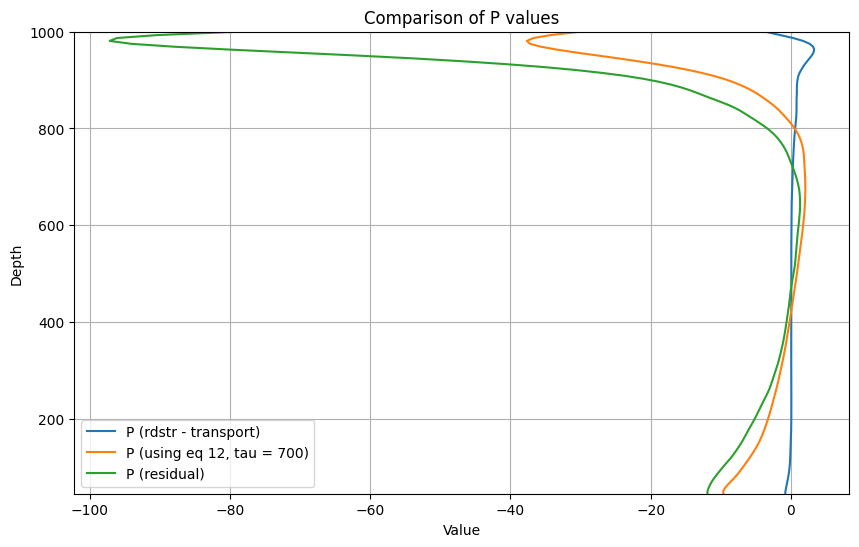

In [28]:
plt.figure(figsize=(10, 6))

# Plot P_subtract
plt.plot(P_subtract[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z, label='P (rdstr - transport)')

# Plot P_direct
plt.plot(P_direct[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z, label='P (using eq 12, tau = 700)')

# Plot P residual
plt.plot(P[timeStep] * pbl_height[timeStep] / (wstar[timeStep] * theta_star[timeStep]), z, label='P (residual)')

plt.ylim(45, 1000)
plt.title('Comparison of P values')
plt.xlabel('Value')
plt.ylabel('Depth')
plt.legend()
plt.grid(True)

plt.show()

## Equation Discovery

We do this with the `PySR` package for symbolic regression. As stated by their github, this is "a machine learning task where the goal is to find an interpretable symbolic expression that optimizes some objective."

We import the library down here because sometimes it takes an annoyingly long number of seconds. 

In [29]:
import pysr
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Step 1: All moments in time, one layer

Here we take a single layer, at perhaps the 60th index of z, like `z[60] = 363` across all 120 minutes of time. We will do this for all different versions of $P$. 

In [30]:
z[60]

indices = np.s_[:, 60]

In [31]:
y0 = P[indices]
y1 = P_direct[indices]
# y2 = P_subtract[:,60]

x0 = wtheta[indices]
x1 = sigma_th[indices]
x2 = sigma_2[indices]
x3 = dTheta_dz[indices]

X = np.column_stack([x0, x1, x2, x3])
print(y0.shape, y1.shape, X.shape)#, y2.shape)

(28,) (28,) (28, 4)


Setting up our model with just basic unitary operators 

In [32]:
model0 = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    # unary_operators=[
    #     "cos",
    #     "exp",
    #     "sin",
    #     "inv(x) = 1/x",
    #     "square",
    #     "cube",
    #     # ^ Custom operator (julia syntax)
    # ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    # batching = True,
    # batch_size = 1000,
)

model1 = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    # unary_operators=[
    #     "cos",
    #     "exp",
    #     "sin",
    #     "inv(x) = 1/x",
    #     "square",
    #     "cube",
    #     # ^ Custom operator (julia syntax)
    # ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    # batching = True,
    # batch_size = 1000,
)

# model2 = PySRRegressor(
#     niterations=100,  # < Increase me for better results
#     binary_operators=["+", "*", "-", "/"],
#     # unary_operators=[
#     #     "cos",
#     #     "exp",
#     #     "sin",
#     #     "inv(x) = 1/x",
#     #     "square",
#     #     "cube",
#     #     # ^ Custom operator (julia syntax)
#     # ],
#     extra_sympy_mappings={"inv": lambda x: 1 / x},
#     # ^ Define operator for SymPy as well
#     elementwise_loss="loss(prediction, target) = (prediction - target)^2",
#     # ^ Custom loss function (julia syntax)
#     # batching = True,
#     # batch_size = 1000,
# )

In [33]:
model0.fit(X,y0)
model1.fit(X,y1)
# model2.fit(X,y2)

Compiling Julia backend...


c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.600e+05
Head worker occupation: 37.1%
Progress: 396 / 1500 total iterations (26.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.237e-08  1.594e+01  y = -0.00015442
3           2.567e-10  2.234e+00  y = -0.055338 * x₁
5           2.417e-10  3.018e-02  y = -0.055163 * (x₁ + 6.6761e-05)
9           1.824e-10  7.031e-02  y = ((1.1682 + x₀) - 1.6483) * (0.12818 * x₁)
15          1.721e-10  9.695e-03  y = (0.056179 * x₁) * (((1.178 + 1.412) * (x₀ + x₁)) - (1.178 ...
                                  - x₀))
19          1.672e-10  7.261e-03  y = (0.040678 * x₁) * ((x₁ * (((-2.0505 / 0.022203) * x₂) * -0...
                                  .26095)) - ((0.84387 * 1.8741) - x₀))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expr

c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.120e+05
Head worker occupation: 18.9%
Progress: 723 / 1500 total iterations (48.200%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.030e-08  1.594e+01  y = -0.00010382
3           7.424e-11  2.466e+00  y = -0.03741 * x₁
5           7.329e-11  6.449e-03  y = (x₃ - 0.037384) * x₁
7           5.632e-11  1.317e-01  y = ((x₃ / x₀) - 0.037384) * x₁
11          4.162e-11  7.564e-02  y = 0.38255 * ((-0.049411 * x₀) * ((x₀ + 0.068885) - -0.14879)...
                                  )
17          4.030e-11  5.334e-03  y = (((x₃ / x₁) + -0.86884) + x₀) * ((-0.064816 * 0.66955) * (...
                                  (x₃ / 0.13628) - x₁))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.960e+05
Head 

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                     -0.00010382061   
	1        2.466251                                  -0.037410434 * x1   
	2        0.006449                            (x3 - 0.037383795) * x1   
	3        0.131667                     ((x3 / x0) - 0.037383795) * x1   
	4        0.120935  0.51996166 * ((-0.049410626 * x0) * (x0 - -0.1...   
	5        0.030346  0.3825523 * ((-0.049410626 * x0) * ((x0 + 0.06...   
	6  >>>>  0.135370  (((-0.000103820545 / x1) + -0.8688355) + x0) *...   
	7        0.000378  ((((-0.000103820545 / x1) + x3) + -0.8688355) ...   
	
	           loss  complexity  
	0  1.029858e-08           1  
	1  7.423676e-11           3  
	2  7.328539e-11           5  
	3  5.631871e-11           7  
	4  4.421910e-11           9  
	5  4.161516e-11          11  
	6  1.847180e-11          17  
	7  1.845784e-11          19  
]

Looking at last equation:

In [34]:
for model in (model0, model1): #, model2):
    equations = model.equations_
    print(equations.shape)
    display(equations)
    print(model, "Final Equation: ")
    display(equations.iloc[-1, 4])

(5, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,2.236534e-08,0.000000,-0.00015442484,-0.000154424840000000,PySRFunction(X=>-0.000154424840000000)
1,3,2.567047e-10,2.233671,-0.055337816 * x1,-0.055337816*x1,PySRFunction(X=>-0.055337816*x1)
2,5,1.778876e-10,0.183387,(-0.062027328 + x1) * x1,x1*(x1 - 0.062027328),PySRFunction(X=>x1*(x1 - 0.062027328))
3,7,1.666768e-10,0.032548,(-0.062027328 + x1) * (x1 - x3),(x1 - 0.062027328)*(x1 - x3),PySRFunction(X=>(x1 - 0.062027328)*(x1 - x3))
4,9,1.529121e-10,0.043097,(-0.062027328 + (x1 * x2)) * (x1 - x3),(x1 - x3)*(x1*x2 - 0.062027328),PySRFunction(X=>(x1 - x3)*(x1*x2 - 0.062027328))


PySRRegressor.equations_ = [
	   pick     score                                equation          loss  \
	0        0.000000                          -0.00015442484  2.236534e-08   
	1        2.233671                       -0.055337816 * x1  2.567047e-10   
	2  >>>>  0.183387                (-0.062027328 + x1) * x1  1.778876e-10   
	3        0.032548         (-0.062027328 + x1) * (x1 - x3)  1.666768e-10   
	4        0.043097  (-0.062027328 + (x1 * x2)) * (x1 - x3)  1.529121e-10   
	
	   complexity  
	0           1  
	1           3  
	2           5  
	3           7  
	4           9  
] Final Equation: 


(x1 - x3)*(x1*x2 - 0.062027328)

(8, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,1.029858e-08,0.000000,-0.00010382061,-0.000103820610000000,PySRFunction(X=>-0.000103820610000000)
1,3,7.423676e-11,2.466251,-0.037410434 * x1,-0.037410434*x1,PySRFunction(X=>-0.037410434*x1)
2,5,7.328539e-11,0.006449,(x3 - 0.037383795) * x1,x1*(x3 - 0.037383795),PySRFunction(X=>x1*(x3 - 0.037383795))
3,7,5.631871e-11,0.131667,((x3 / x0) - 0.037383795) * x1,x1*(-0.037383795 + x3/x0),PySRFunction(X=>x1*(-0.037383795 + x3/x0))
4,9,4.421910e-11,0.120935,0.51996166 * ((-0.049410626 * x0) * (x0 - -0.1...,-0.0256916311165992*x0*(x0 + 0.14878935),PySRFunction(X=>-0.0256916311165992*x0*(x0 + 0...
5,11,4.161516e-11,0.030346,0.3825523 * ((-0.049410626 * x0) * ((x0 + 0.06...,-0.0189021486207398*x0*(x0 + 0.217674356),PySRFunction(X=>-0.0189021486207398*x0*(x0 + 0...
6,17,1.847180e-11,0.135370,(((-0.000103820545 / x1) + -0.8688355) + x0) *...,(0.0433979574020824*x1 - 0.318436323364284*x3)...,PySRFunction(X=>(0.0433979574020824*x1 - 0.318...
7,19,1.845784e-11,0.000378,((((-0.000103820545 / x1) + x3) + -0.8688355) ...,(0.0433979574020824*x1 - 0.318436323364284*x3)...,PySRFunction(X=>(0.0433979574020824*x1 - 0.318...


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                     -0.00010382061   
	1        2.466251                                  -0.037410434 * x1   
	2        0.006449                            (x3 - 0.037383795) * x1   
	3        0.131667                     ((x3 / x0) - 0.037383795) * x1   
	4        0.120935  0.51996166 * ((-0.049410626 * x0) * (x0 - -0.1...   
	5        0.030346  0.3825523 * ((-0.049410626 * x0) * ((x0 + 0.06...   
	6  >>>>  0.135370  (((-0.000103820545 / x1) + -0.8688355) + x0) *...   
	7        0.000378  ((((-0.000103820545 / x1) + x3) + -0.8688355) ...   
	
	           loss  complexity  
	0  1.029858e-08           1  
	1  7.423676e-11           3  
	2  7.328539e-11           5  
	3  5.631871e-11           7  
	4  4.421910e-11           9  
	5  4.161516e-11          11  
	6  1.847180e-11          17  
	7  1.845784e-11          19  
] Final Equation: 


(0.0433979574020824*x1 - 0.318436323364284*x3)*(x0 + x3 - 0.8688355 - 0.000103820545/x1)

### Step 2: One moment in time, a few layers

This is probably too simple, but we'll see. Just going to take z from 60 to 80, at one point in time, and see what we get. 

In [35]:
wtheta[14,60:80]

indices = np.s_[14, 60:80]

In [36]:
y0 = P[indices]
y1 = P_direct[indices]
# y2 = P_subtract[:,60]

x0 = wtheta[indices]
x1 = sigma_th[indices]
x2 = sigma_2[indices]
x3 = dTheta_dz[indices]

X = np.column_stack([x0, x1, x2, x3])
print(y0.shape, y1.shape, X.shape)#, y2.shape)

(20,) (20,) (20, 4)


In [37]:
model3 = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    # unary_operators=[
    #     "cos",
    #     "exp",
    #     "sin",
    #     "inv(x) = 1/x",
    #     "square",
    #     "cube",
    #     # ^ Custom operator (julia syntax)
    # ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    # batching = True,
    # batch_size = 1000,
)

model4 = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    # unary_operators=[
    #     "cos",
    #     "exp",
    #     "sin",
    #     "inv(x) = 1/x",
    #     "square",
    #     "cube",
    #     # ^ Custom operator (julia syntax)
    # ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    # batching = True,
    # batch_size = 1000,
)

In [38]:
model3.fit(X,y0)
model4.fit(X,y1)

c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.980e+05
Head worker occupation: 21.3%
Progress: 679 / 1500 total iterations (45.267%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           7.170e-11  1.594e+01  y = -5.9954e-05
3           1.176e-12  2.055e+00  y = -0.069674 * x₁
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.910e+05
Head worker occupation: 21.7%
Progress: 1341 / 1500 total iterations (89.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           7.170e-11  1.594e+01  y = -5.9954e-05
3           1.176e-12  2.055e+00  y = -0.069674 * x₁
-----------------------------------------------------------------------------------

c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.050e+05
Head worker occupation: 16.1%
Progress: 708 / 1500 total iterations (47.200%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           2.946e-12  5.314e+00  y = -0.0042979 * x₀
11          1.544e-13  3.685e-01  y = (x₀ / ((-0.056806 - x₂) * 0.82194)) * (x₁ + 0.00083817)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.010e+05
Head worker occupation: 17.8%
Progress: 1407 / 1500 total iterations (93.800%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           8.988e-01  1.594e+01  y = 0.948
3           2.946e-12  7.971e+00  y = -0.0042979 * x₀
11          1.544e-13  3.685e-01  y = (x₀ /

PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                         0.94800407   
	1        13.221982                                  -0.004297942 * x0   
	2  >>>>   0.368538  (x0 / ((-0.056806415 - x2) * 0.821944)) * (x1 ...   
	
	           loss  complexity  
	0  8.987848e-01           1  
	1  2.945698e-12           3  
	2  1.544382e-13          11  
]

In [39]:
for model in (model3, model4):
    equations = model.equations_
    print(equations.shape)
    display(equations)
    print(model, "Final Equation: ")
    display(equations.iloc[-1, 4])

(2, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,7.169808e-11,0.000000,-5.995403e-5,-5.99540300000000e-5,PySRFunction(X=>-0.0000599540300000000)
1,3,1.175909e-12,2.055211,-0.069674134 * x1,-0.069674134*x1,PySRFunction(X=>-0.069674134*x1)


PySRRegressor.equations_ = [
	   pick     score           equation          loss  complexity
	0        0.000000       -5.995403e-5  7.169808e-11           1
	1  >>>>  2.055211  -0.069674134 * x1  1.175909e-12           3
] Final Equation: 


-0.069674134*x1

(3, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,8.987848e-01,0.000000,0.94800407,0.948004070000000,PySRFunction(X=>0.948004070000000)
1,3,2.945698e-12,13.221982,-0.004297942 * x0,-0.004297942*x0,PySRFunction(X=>-0.004297942*x0)
2,11,1.544382e-13,0.368538,(x0 / ((-0.056806415 - x2) * 0.821944)) * (x1 ...,x0*(x1 + 0.0008381717)/(-0.821944*x2 - 0.04669...,PySRFunction(X=>x0*(x1 + 0.0008381717)/(-0.821...


PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                         0.94800407   
	1        13.221982                                  -0.004297942 * x0   
	2  >>>>   0.368538  (x0 / ((-0.056806415 - x2) * 0.821944)) * (x1 ...   
	
	           loss  complexity  
	0  8.987848e-01           1  
	1  2.945698e-12           3  
	2  1.544382e-13          11  
] Final Equation: 


x0*(x1 + 0.0008381717)/(-0.821944*x2 - 0.04669169197076)

### Step 3: All moments in time, a few layers

This is my current best bet. Might have to start using batching here. I think in the others we have too little data. Will take heights 60 to 80 and all instances in time

In [40]:
print(dTheta_dz[:, 60:80].shape, dTheta_dz[:, 60:80].ravel().shape)

indices = np.s_[:, 60:80]

(28, 20) (560,)


In [41]:
y0 = P[indices].ravel()
y1 = P_direct[indices].ravel()
# y2 = P_subtract[:,60]

x0 = wtheta[indices].ravel()
x1 = sigma_th[indices].ravel()
x2 = sigma_2[indices].ravel()
x3 = dTheta_dz[indices].ravel()



X = np.column_stack([x0, x1, x2, x3])
print(y0.shape, y1.shape, X.shape)#, y2.shape)

(560,) (560,) (560, 4)


In [42]:
model5 = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    # unary_operators=[
    #     "cos",
    #     "exp",
    #     "sin",
    #     "inv(x) = 1/x",
    #     "square",
    #     "cube",
    #     # ^ Custom operator (julia syntax)
    # ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    # batching = True,
    # batch_size = 1000,
)

model6 = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    # unary_operators=[
    #     "cos",
    #     "exp",
    #     "sin",
    #     "inv(x) = 1/x",
    #     "square",
    #     "cube",
    #     # ^ Custom operator (julia syntax)
    # ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    # batching = True,
    # batch_size = 1000,
)

In [43]:
model5.fit(X,y0)
model6.fit(X,y1)

c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(



Expressions evaluated per second: 1.830e+05
Head worker occupation: 34.3%
Progress: 419 / 1500 total iterations (27.933%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           2.056e-10  5.314e+00  y = -0.0072118 * x₀
5           1.885e-10  4.336e-02  y = (x₁ + x₀) * -0.0064027
9           1.730e-10  2.148e-02  y = ((x₁ / 0.23469) + x₀) * (-0.5122 * 0.0091075)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.830e+05
Head worker occupation: 28.6%
Progress: 852 / 1500 total iterations (56.800%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.670e-08  1.594e+01  y = -0.00012638
3           2.056e-10  2.199e+00  y = -0.

[ Info: Started!



Expressions evaluated per second: 2.190e+05
Head worker occupation: 24.2%
Progress: 513 / 1500 total iterations (34.200%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.395e-01  1.594e+01  y = -0.37353
3           8.691e-11  7.969e+00  y = x₁ * -0.036972
5           6.123e-11  1.751e-01  y = (x₀ * -0.0049316) + 7.8892e-06
7           4.356e-11  1.703e-01  y = (x₀ * -0.0047063) + (x₃ * 0.20274)
9           2.139e-11  3.556e-01  y = (-0.0047063 * x₀) + (x₃ * (0.57281 * x₂))
11          1.756e-11  9.847e-02  y = (-0.0047063 * x₀) + (x₃ * ((x₂ * 0.57281) * x₂))
13          1.391e-11  1.167e-01  y = (-0.0047063 * x₀) + ((-1.1411 * -0.40989) * ((x₂ * x₃) * 1...
                                  .0015))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evalu

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                       -8.001519e-5   
	1        2.229983                                    x1 * -0.0369719   
	2        0.175080                 (x0 * -0.0049315756) + 7.889175e-6   
	3        0.170325            (x0 * -0.004706319) + (x3 * 0.20273903)   
	4        0.355646      (-0.004706319 * x0) + (x3 * (0.5728057 * x2))   
	5        0.098468  (-0.004706319 * x0) + (x3 * ((x2 * 0.5728057) ...   
	6  >>>>  0.116743  (-0.004706319 * x0) + ((-1.1410744 * -0.409890...   
	7        0.025317  ((((x3 - (x3 - (-0.83526856 - -2.1348982))) * ...   
	
	           loss  complexity  
	0  7.516115e-09           1  
	1  8.690693e-11           3  
	2  6.123244e-11           5  
	3  4.355515e-11           7  
	4  2.138599e-11           9  
	5  1.756309e-11          11  
	6  1.390592e-11          13  
	7  1.194620e-11          19  
]

In [44]:
for model in (model5, model6):
    equations = model.equations_
    print(equations.shape)
    display(equations)
    print(model, "Final Equation: ")
    display(equations.iloc[-1, 4])

(4, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,1.669988e-08,0.000000,-0.00012638443,-0.000126384430000000,PySRFunction(X=>-0.000126384430000000)
1,3,2.055588e-10,2.198712,-0.007211849 * x0,-0.007211849*x0,PySRFunction(X=>-0.007211849*x0)
2,5,1.884820e-10,0.043365,(x1 + x0) * -0.006402701,-0.006402701*x0 - 0.006402701*x1,PySRFunction(X=>-0.006402701*x0 - 0.006402701*x1)
3,9,1.729652e-10,0.021478,((x1 / 0.2346931) + x0) * (-0.5122015 * 0.0091...,-0.0046648705514365*x0 - 0.0198764708099066*x1,PySRFunction(X=>-0.0046648705514365*x0 - 0.019...


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                     -0.00012638443   
	1  >>>>  2.198712                                  -0.007211849 * x0   
	2        0.043365                           (x1 + x0) * -0.006402701   
	3        0.021478  ((x1 / 0.2346931) + x0) * (-0.5122015 * 0.0091...   
	
	           loss  complexity  
	0  1.669988e-08           1  
	1  2.055588e-10           3  
	2  1.884820e-10           5  
	3  1.729652e-10           9  
] Final Equation: 


-0.0046648705514365*x0 - 0.0198764708099066*x1

(8, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,7.516115e-09,0.000000,-8.001519e-5,-8.00151900000000e-5,PySRFunction(X=>-0.0000800151900000000)
1,3,8.690693e-11,2.229983,x1 * -0.0369719,-0.0369719*x1,PySRFunction(X=>-0.0369719*x1)
2,5,6.123244e-11,0.175080,(x0 * -0.0049315756) + 7.889175e-6,7.889175e-6 - 0.0049315756*x0,PySRFunction(X=>7.889175e-6 - 0.0049315756*x0)
3,7,4.355515e-11,0.170325,(x0 * -0.004706319) + (x3 * 0.20273903),-0.004706319*x0 + 0.20273903*x3,PySRFunction(X=>-0.004706319*x0 + 0.20273903*x3)
4,9,2.138599e-11,0.355646,(-0.004706319 * x0) + (x3 * (0.5728057 * x2)),-0.004706319*x0 + 0.5728057*x2*x3,PySRFunction(X=>-0.004706319*x0 + 0.5728057*x2...
5,11,1.756309e-11,0.098468,(-0.004706319 * x0) + (x3 * ((x2 * 0.5728057) ...,-0.004706319*x0 + 0.5728057*x2**2*x3,PySRFunction(X=>-0.004706319*x0 + 0.5728057*x2...
6,13,1.390592e-11,0.116743,(-0.004706319 * x0) + ((-1.1410744 * -0.409890...,-0.004706319*x0 + 0.468434535056765*x2*x3,PySRFunction(X=>-0.004706319*x0 + 0.4684345350...
7,19,1.194620e-11,0.025317,((((x3 - (x3 - (-0.83526856 - -2.1348982))) * ...,-0.004706319*x0 + x3*(0.651943483387356*x2 - 0...,PySRFunction(X=>-0.004706319*x0 + x3*(0.651943...


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                       -8.001519e-5   
	1        2.229983                                    x1 * -0.0369719   
	2        0.175080                 (x0 * -0.0049315756) + 7.889175e-6   
	3        0.170325            (x0 * -0.004706319) + (x3 * 0.20273903)   
	4        0.355646      (-0.004706319 * x0) + (x3 * (0.5728057 * x2))   
	5        0.098468  (-0.004706319 * x0) + (x3 * ((x2 * 0.5728057) ...   
	6  >>>>  0.116743  (-0.004706319 * x0) + ((-1.1410744 * -0.409890...   
	7        0.025317  ((((x3 - (x3 - (-0.83526856 - -2.1348982))) * ...   
	
	           loss  complexity  
	0  7.516115e-09           1  
	1  8.690693e-11           3  
	2  6.123244e-11           5  
	3  4.355515e-11           7  
	4  2.138599e-11           9  
	5  1.756309e-11          11  
	6  1.390592e-11          13  
	7  1.194620e-11          19  
] Final Equation: 


-0.004706319*x0 + x3*(0.651943483387356*x2 - 0.138626778402816)